# Workflow

## 1. Data inspection

Please check `EDA.ipynb'

## 2. Data prepreocessing and split

In [3]:
import os
import json
import re
import cv2
import numpy as np

def extract_id_from_filename(filename):
    # Assuming the ID is the part between the last underscore and the dot
    if filename[-3:] == "jpg":
        match = re.search(r'_(\d+)\.', filename)
    else:
        match = re.search(r'_(\d+)_', filename)
    return int(match.group(1)) if match else None

def read_images_recursive(folder_path):
    image_data = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith((".jpg", ".jpeg")):
                image_path = os.path.join(root, file)
                image_id = extract_id_from_filename(file)
                data = {
                    "Id": image_id,
                    "Storm_Name": folder_name,
                    "Image_Path": image_path
                }
                image_data.append(data)
    return image_data

def read_feature_jsons_recursive(folder_path):
    feature_data_list = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith("_features.json"):
                image_id = extract_id_from_filename(file)
                with open(os.path.join(root, file), "r") as json_file:
                    json_data = json.load(json_file)
                    data = {
                        "Id": image_id,
                        "Storm_Name": folder_name,
                        "Relative_time": int(json_data["relative_time"]),
                        "Ocean": int(json_data["ocean"]),
                    }
                    feature_data_list.append(data)
    return feature_data_list

def read_label_jsons_recursive(folder_path):
    label_data_list = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith("_label.json"):
                image_id = extract_id_from_filename(file)
                with open(os.path.join(root, file), "r") as json_file:
                    json_data = json.load(json_file)
                    data = {
                        "Id": image_id,
                        "Storm_Name": folder_name,
                        "Wind_Speed": json_data["wind_speed"],
                    }
                    label_data_list.append(data)
    return label_data_list

In [4]:
# df = read_label_jsons_recursive("./data/Surprise_Storm/")
# import pandas as pd
# df = pd.DataFrame(df)
# df

## 3. Task 1


In [4]:
import sys

# If 'ConvLSTM.py' is in a subdirectory, you can add that directory to sys.path like this:
sys.path.append('./ACDS')
sys.path.append('./ACDS/Image')
sys.path.append('./ACDS/Speed')

In [5]:
# import torch
from ACDS.Image import *

In [9]:
import torch

In [7]:
model1 = torch.load('./ACDS/Image/model_t1/model1_final.pth')
model2 = torch.load('./ACDS/Image/model_t1/model1_final.pth')

In [13]:
surprise_data = StormDataset("./data/Surprise_Storm",'tst',8,time_gap=1)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

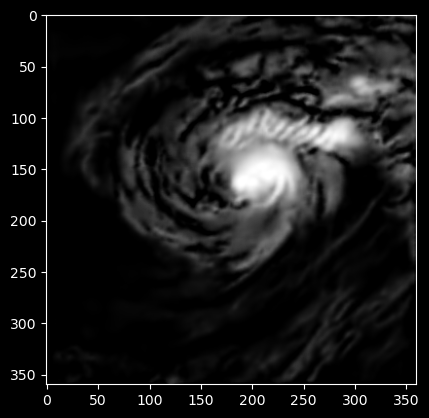

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def save_tensor_as_jpeg(tensor, filename):
    """Save tensor as a JPEG image, resized to 366x366."""
    to_pil = transforms.ToPILImage()
    resize = transforms.Resize((366, 366))  # Resize image to 366x366
    pil_img = to_pil(tensor.squeeze().byte())
    resized_img = resize(pil_img)  # Resize the image
    resized_img.save(filename)

def shift_images(images):
    """Shift image sequence forward by one"""
    for i in range(images.shape[1] - 1):
        images[0, i, :, :, :] = images[0, i + 1, :, :, :]
    images[0,-1,0,:,:] = images[0,-2,0,:,:]
    return images

def generate_future(future_step:int, dataset:StormDataset, model, gap = 1, seq = 8):
  cnt = len(dataset)
  full_inputs , _ = dataset[cnt - 1]
  last_idx = cnt - gap
  inputs, _ = dataset[last_idx]

  images = inputs['image'].detach().unsqueeze(0).to(device)
  full_images = full_inputs['image'].detach().unsqueeze(0).to(device)

  pre = full_images[0,-1,0,:,:]
  model.eval()
  if gap > 1:
    fig, axes = plt.subplots(1, gap, figsize=(12, 6))
  with torch.no_grad():
    images = images.to(device)
    # Initial update of the image sequence
    images = shift_images(images)
    for i in range(future_step):
      pic = model(images)
      # Convert to PIL Image
      to_pil = transforms.ToPILImage()
      pic = (pic + 1) /2 *255
      pil_img = to_pil(pic.squeeze().byte())
      # Save as JPEG
      filename = 'tst_' + str(cnt + i + seq + (0 if gap == 1 else gap-1)) + '.jpg'
      filename = os.path.join('./data/results', filename)
      save_tensor_as_jpeg(pic, filename)

      pic = pic.squeeze().cpu().numpy()
      if gap > 1:
        axes[i].imshow(pic, 'gray')
        images[0,-1,0,:,:] = pre
        pre = torch.tensor(pic)
      else:
        plt.imshow(pic, 'gray')
        images[0,-1,0,:,:] = torch.tensor(pic)

      images = shift_images(images)
      
# tst_251.jpg
generate_future(1, surprise_data, model1)

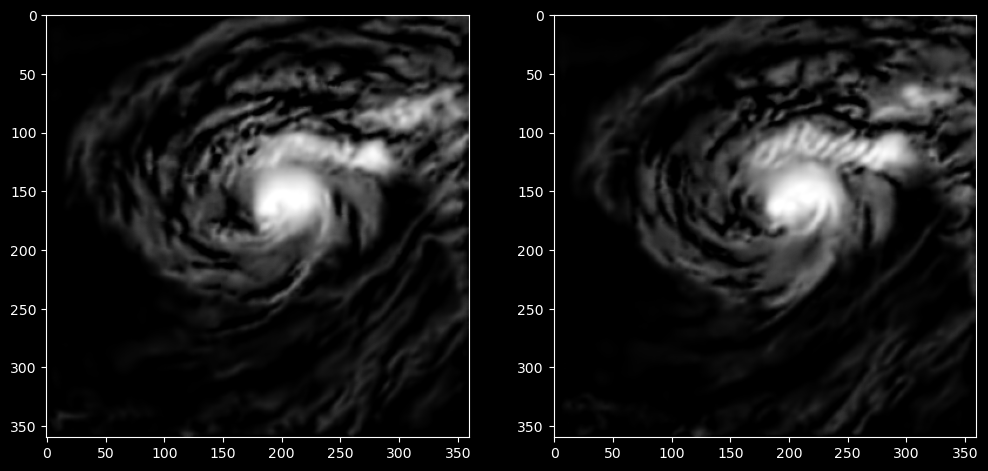

In [17]:
# tst_252.jpg and tst_253.jpg
generate_future(2, surprise_data, model2, 2)

## 4. Task 2

In [1]:
from ACDS.Speed import *
from ACDS.Speed import helper, dataloader, model

In [2]:
data = helper.get_raw_data("./data/Surprise_Storm_Predicted")
data.to_csv("./data/Surprise_Storm_Predicted.csv", index=False)

In [9]:
data[-13:] # generate a dummy dataset to show the final result of the best model

,Storm_Name,Id,Wind_Speed,Relative_time,Ocean,Image_Path
242,tst,6,37,12599,1,./data/Surprise_Storm_Predicted/tst/tst_006.jpg
243,tst,186,105,401400,1,./data/Surprise_Storm_Predicted/tst/tst_186.jpg
244,tst,174,121,374401,1,./data/Surprise_Storm_Predicted/tst/tst_174.jpg
245,tst,240,60,518400,1,./data/Surprise_Storm_Predicted/tst/tst_240.jpg
246,tst,91,87,196199,1,./data/Surprise_Storm_Predicted/tst/tst_091.jpg
247,tst,15,46,32399,1,./data/Surprise_Storm_Predicted/tst/tst_015.jpg
248,tst,59,65,126000,1,./data/Surprise_Storm_Predicted/tst/tst_059.jpg
249,tst,60,66,129599,1,./data/Surprise_Storm_Predicted/tst/tst_060.jpg
250,tst,236,63,509400,1,./data/Surprise_Storm_Predicted/tst/tst_236.jpg
251,tst,26,57,55801,1,./data/Surprise_Storm_Predicted/tst/tst_026.jpg


In [2]:
storm_names = ['tst']
image_size = 256
sequence_length = 3
model_version = 'v3_1'
cnn_output_size =128  # example size after CNN feature extraction
hidden_size = 256  # LSTM hidden layer size
num_layers = 10  # number of LSTM layers
root_dir = "./data/Surprise_Storm_Predicted"
raw_data_dir = "./data/Surprise_Storm_Predicted.csv"

datasets = dataloader.make_datasets(root_dir=root_dir, 
                 raw_data_dir=raw_data_dir, 
                 storm_names=storm_names, 
                 transform=helper.transformer(image_size=image_size, repair=True),
                 split_ratio=1, 
                 sequence_length=sequence_length,
                 additional_features=['relative_time'],
                 label_type='wind_speed')

dataloaders = dataloader.make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import pandas as pd
features_json = read_feature_jsons_recursive("./data/Surprise_Storm_Predicted")
df_features = pd.DataFrame(features_json)

In [7]:
# sort the dataframe by Relative_time
df_features = df_features.sort_values(by=['Relative_time'])
Relative_time = df_features['Relative_time']
# Relative_time  to list
Relative_time = Relative_time.tolist()

In [8]:
Relative_time = Relative_time[-13:]

In [12]:
import torch
import torch.nn as nn  
 
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")

Cuda installed! Running on device!


In [14]:
from ACDS.Speed.model import CNNLSTM_V3
from ACDS.Speed.helper import load_model, score_matrix
criterion = nn.MSELoss()
m = CNNLSTM_V3(cnn_output_size, hidden_size, num_layers, num_features=1, image_size=image_size)
o = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './ACDS/Speed/models', 'cnn_lstm_v3_1_265', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][0], criterion, device=device)
results = predicts[-13:]
predicts = pd.DataFrame([Relative_time, results]).T
predicts.columns = ['Relative_time', 'Wind_Speed']
predicts.to_csv("./data/results/nicholas_windpredictions.csv", index=False, header=False)

ACDS/Speed/models/cnn_lstm_v3_1_265.pth
[INFO] Loading model from: ACDS/Speed/models/cnn_lstm_v3_1_265.pth at epoch: 265


In [15]:
predicts

,Relative_time,Wind_Speed
0,522000.0,58.893951
1,523800.0,57.903469
2,525601.0,57.914341
3,529199.0,57.433643
4,530999.0,56.595448
5,532799.0,56.272369
6,534599.0,55.930000
7,536398.0,55.351665
8,539999.0,54.783096
9,541799.0,53.490471
